In [1]:
%%capture
%run ch04_linear_algebra.ipynb
%run ch11_maching_learning.ipynb

In [2]:
# Majority vote

from typing import List
from collections import Counter

def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    
    return winner

assert raw_majority_vote(['a', 'b', 'c', 'b']) == 'b'

In [3]:
def majority_vote(labels: List[str]) -> str:
    """Assumes that labels are ordered from nearest to farthest"""
    
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    
    num_winners = len([count 
                       for count in vote_counts.values() 
                       if count == winner_count])
    
    if num_winners == 1:
        return winner # unique winner
    else:
        return majority_vote(labels[:-1]) # try again without the farthest
    
assert majority_vote(['a', 'b', 'c', 'b', 'a']) == 'b' # Tie, so look at first 4, then 'b'

In [4]:
# Simple k-NN

from typing import NamedTuple

class LabeledPoint(NamedTuple):
    point: Vector
    label: str
        
def knn_classify(k: int, 
                 labeled_points: List[LabeledPoint], 
                 new_point: Vector) -> str:
    
    # Order the labeled points from nearest and farthest
    by_distance = sorted(labeled_points, 
                         key=lambda lp: distance(lp.point, new_point))
    
    # Find the labels for the k closest
    k_nearest_lables = [lp.label for lp in by_distance[:k]]
    
    # and let them vote
    return majority_vote(k_nearest_lables)

In [5]:
from typing import Dict
import csv
from collections import defaultdict

def parse_iris_row(row: List[str]) -> LabeledPoint:
    """
    sepal_length, sepal_width, petal_length, petal_width, class
    """
    measurements = [float(value) for value in row[:-1]] # features (except class)
    label = row[-1].split("-")[-1] # label
    
    return LabeledPoint(measurements, label)

with open('data/iris.data') as f:
    reader = csv.reader(f)
    iris_data = [parse_iris_row(row) for row in reader]
    
# We will also group the points by species (labels) so we can plot them
points_by_species: Dict[str, List[Vector]] = defaultdict(list)

for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

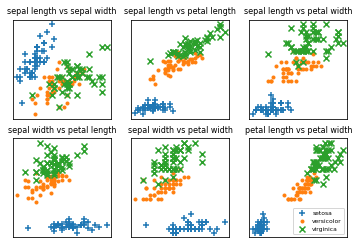

In [6]:
from matplotlib import pyplot as plt

metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) 
         for i in range(4) 
         for j in range(4) 
         if i < j]
marks = ['+', '.', 'x'] # 3 classes

fig, ax = plt.subplots(2, 3)

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])
        
        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)

ax[-1][-1].legend(loc='lower right', prop={'size': 6})
plt.show()

In [7]:
# Simple k-NN on Iris dataset

import random
from typing import Tuple

random.seed(8)
iris_train, iris_test = split_data(iris_data, 0.7)

# assert len(iris_train) == 0.7 * 150
# assert len(iris_test) == 0.3 * 150

# track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label
    
    if predicted == actual: 
        num_correct += 1
        
    confusion_matrix[(predicted, actual)] += 1
    
pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix)

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 15, ('virginica', 'virginica'): 14, ('versicolor', 'virginica'): 1, ('versicolor', 'versicolor'): 15})


In [8]:
# The curse of dimensionality

def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim)) 
            for _ in range(num_pairs)]

In [9]:
import tqdm
dimensions = range(1, 101)

avg_distances = []
min_distances = []

random.seed(8)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"): # for each dimenision (d=1,2,3,...,100),
    distances = random_distances(dim, 10000) # distances between 10000 random pairs
    avg_distances.append(sum(distances) / 10000)
    min_distances.append(min(distances))

Curse of Dimensionality: 100%|████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.38it/s]


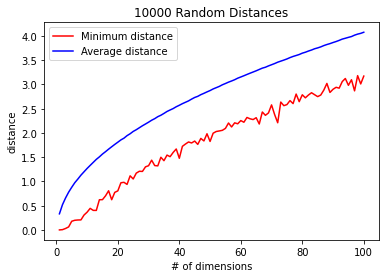

In [10]:
# As the number of dimensions increases, the average distance between points increases

plt.title("10000 Random Distances")
plt.plot(dimensions, min_distances, 'r', label='Minimum distance')
plt.plot(dimensions, avg_distances, 'b', label='Average distance')
plt.xlabel('# of dimensions')
plt.ylabel('distance')
plt.legend(loc=2)
plt.show()

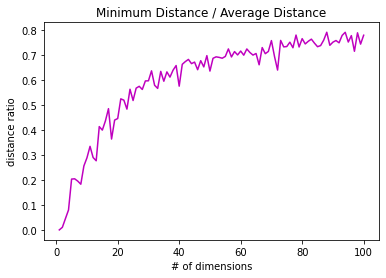

In [11]:
min_avg_ratio = [min_dist / avg_dist 
                 for min_dist, avg_dist 
                 in zip(min_distances, avg_distances)]

plt.title("Minimum Distance / Average Distance")
plt.plot(dimensions, min_avg_ratio, 'm')
plt.xlabel('# of dimensions')
plt.ylabel('distance ratio')
plt.show()